<a href="https://colab.research.google.com/github/AaryaAshok77/BrainTumourDetector_DeepLearning/blob/main/Brain_Tumour_Detector_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Setup

## Importing Packages

In [2]:

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score #? Helps form a yes no matrix for learning, check accuracy of our model
import cv2 #? Helps read image data -> Computer Vision

## Reading the images

In [11]:
# from google.colab import drive
# drive.mount ('/content/drive', force_remount=True)
# tumour = []
# path_tumour = "/content/drive/MyDrive/DataSets/brain_tumor_dataset/yes/*.jpg"
# path_healthy = "/content/drive/MyDrive/DataSets/brain_tumor_dataset/no/*.jpg"


#* Reading the tumorous images from the dataset
tumour = []
path_tumour = "brain_tumor_dataset/yes/*.jpg"

for f in glob.iglob(path_tumour):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128)) #? Resizing the image to 128x128
    b, g, r = cv2.split(img) #?S plitting the image into its RGB components
    img = cv2.merge([r, g, b], img) #? Merging the RGB components to form the image
    tumour.append(img)
print(f"Tumorous: {len(tumour)}")

#* Reading the healthy images from the dataset
healthy = []
path_healthy = "brain_tumor_dataset/no/*.jpg"

for f in glob.iglob(path_healthy):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b], img)
    healthy.append(img)
print(f"Healthy: {len(healthy)}")

154
97


In [12]:
tumour = np.array(tumour)
healthy = np.array(healthy)
print(f"Tumorous: {tumour.shape}") #? 155 images of 128x128 pixels with 3 channels (RGB)
print(f"Healthy: {healthy.shape}") #? 98 images of 128x128 pixels with 3 channels (RGB)

In [15]:
all = np.concatenate((tumour, healthy)) #? Concatenating the tumorous and healthy images to form a single dataset
print(f"All: {all.shape}") #? 253 images of 128x128 pixels with 3 channels (RGB)

All: (251, 128, 128, 3)


# Visualizing the MRI image

In [47]:
def plot_random_img(healthy, tumour, n):
    healthy_imgs =  healthy[np.random.choice(healthy.shape[0], n, replace=False)] #? Randomly selecting 5 healthy images
    tumour_imgs =  tumour[np.random.choice(tumour.shape[0], n, replace=False)] #? Randomly selecting 5 tumorous images

    plt.figure(figsize=(16, 9)) #? Setting the size of the plot
    for img in range(n):
        plt.subplot(1, n, img+1) #? 1-> Row, num-> Column, img+1-> Index
        plt.title('Healthy')
        plt.imshow(healthy_imgs[img])

    plt.figure(figsize=(16, 9))
    for img in range(n):
        plt.subplot(2, n, img+1+n) #? 2-> Row, num-> Column, img+1+n-> Index
        plt.title('Tumorous')
        plt.imshow(tumour_imgs[img])

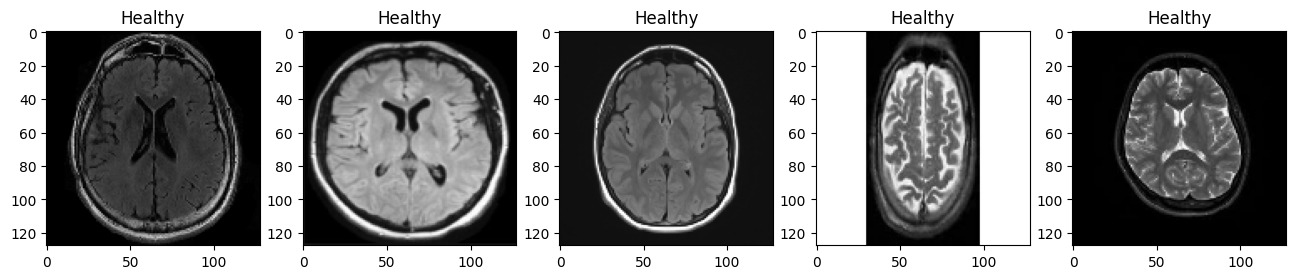

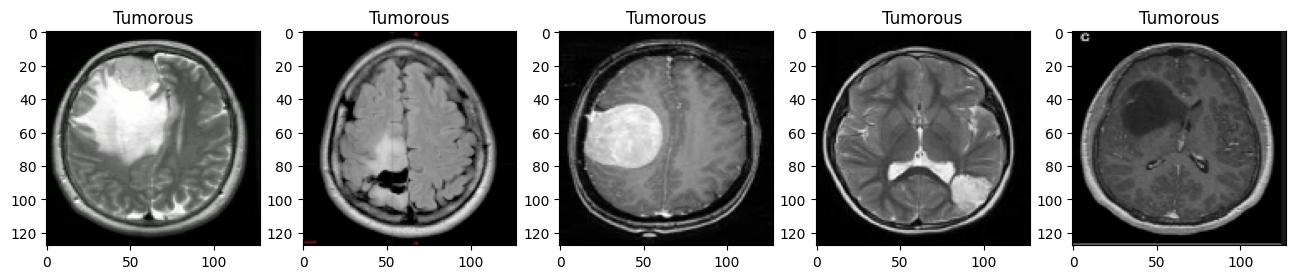

In [48]:
plot_random_img(healthy, tumour, 5)